In [1]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

import math
from scipy          import stats
from scipy.optimize import curve_fit

from scipy.signal import savgol_filter

from functools         import partial
from matplotlib.colors import LogNorm

from scipy.signal import savgol_filter

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 14

In [5]:
import matplotlib
# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [6]:
fav_col = '#418094'

## Ideally we want to use sg_filter_window = 30 and min_dist = 30, but I'll use 50 since we already have the SiPMs calibrated with those values

In [7]:
max_smpl_bsl        = 650
std_bsl_thr         = 15
sg_filter_window    = 50
sg_filter_polyorder = 3
thr_ADC             = 50 #ths for the noise suppression and peak finder after SG filter
thr_spe             = 0.5
min_dist            = 50 #min distance between peaks for peakutils
thres_abs           = True

#normal_chs  = range(9) Channel 5 is dead
normal_chs  = [0, 1, 2, 3, 4, 6, 7, 8]
trigger_chs = [9, 10, 11]

In [8]:
## Gains
gains = {0:  228.78612544813345,
         1:  206.5098755175535,
         2:  221.70401991464104,
         3:  215.32349719234927,
         4:  224.9179650548769,
         5:  230.50715541568943,
         6:  226.72397898148785,
         7:  231.6381789944484,
         8:  225.59700099028822,
         9:  630.80392091,
         10: 621.89586331,
         11: 583.50579627}

### Gains for the SG method
gains_sg = {0: 215.9136058765189,
            1: 197.6173531487562,
            2: 208.09116790825274,
            3: 201.34467649924105,
            4: 209.56593611368697,
            6: 212.5709132476739,
            7: 217.5102713630135,
            8: 211.7111175113524,
            9: 601.3149156238308,
            10: 588.0378833443852,
            11: 555.1266908913976}

In [9]:
def process_wfs(filename,
                max_smpl_bsl=max_smpl_bsl,
                sg_filter_window=sg_filter_window,
                sg_filter_polyorder=sg_filter_polyorder,
                thr_spe=thr_spe):
    
    RawTree = uproot.open(filename)['RawTree']

    subt_wfs = {ch: pf.subtract_baseline(pf.wfs_from_rawtree(RawTree, ch),
                                              mode=True,
                                              wf_range_bsl=(0, max_smpl_bsl))
                     for ch in normal_chs}
    
    zs_swfs = {ch: pf.noise_suppression(subt_wfs[ch]/gains[ch],
                                             threshold=thr_spe)
                        for ch in normal_chs}

    sg_filt_swfs = {ch: savgol_filter(subt_wfs[ch],
                                           window_length=sg_filter_window,
                                           polyorder=sg_filter_polyorder)
                         for ch in normal_chs}
    
    zs_sg_filt_swfs = {ch: pf.noise_suppression(sg_filt_swfs[ch]/gains_sg[ch],
                                                     threshold=thr_spe)
                            for ch in normal_chs}
    
    ## Trigger SiPMs
    trigg_cwfs = {ch: np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl))
                                     for wf in pf.wfs_from_rawtree(RawTree, ch)])
                       for ch in trigger_chs}
    
    zs_trigg = {ch: pf.noise_suppression(trigg_cwfs[ch]/gains[ch],
                                              threshold=thr_spe)
                             for ch in trigger_chs}
    
    
    sg_filt_trigg = {ch: savgol_filter(trigg_cwfs[ch],
                                            window_length=sg_filter_window,
                                            polyorder=sg_filter_polyorder)
                          for ch in trigger_chs}
    
    
    
    zs_sg_filt_trigg = {ch: pf.noise_suppression(sg_filt_trigg[ch]/gains_sg[ch],
                                                      threshold=thr_spe)
                             for ch in trigger_chs}
    
    return subt_wfs, zs_swfs, sg_filt_swfs, zs_sg_filt_swfs, trigg_cwfs, zs_trigg, sg_filt_trigg, zs_sg_filt_trigg


def get_index_and_heights(subt_wfs,
                          zs_sg_filt_swfs,
                          trigg_cwfs,
                          zs_sg_filt_trigg,
                          thres=thr_spe,
                          min_dist=min_dist,
                          thres_abs=thres_abs):

    partial_get_peaks_peakutils_spe = partial(pf.get_peaks_peakutils, thres=thr_spe, min_dist=min_dist, thres_abs=thres_abs)
    
    idx_peaks = {ch: np.array(list(map(partial_get_peaks_peakutils_spe, zs_sg_filt_swfs[ch])), dtype=object)
                         for ch in normal_chs}
    
    idx_peaks_thr = {ch: np.array([pf.get_values_thr_from_zswf(wf, idx_peaks[ch][i])
                                   for i,wf in enumerate(zs_sg_filt_swfs[ch])], dtype=object)
                             for ch in normal_chs}
    
    height_peaks = {ch: np.array([wf[idx_peaks[ch][i]] if len(idx_peaks[ch][i])!=0 else np.array([])
                                  for i, wf in enumerate(subt_wfs[ch])], dtype=object)
                                  for ch in normal_chs}
    
    height_peaks_sg = {ch: np.array([pf.peak_height(wf, idx_peaks[ch][i])
                                     for i,wf in enumerate(zs_sg_filt_swfs[ch])], dtype=object)
                            for ch in normal_chs}
    
    #height_peaks_deconv_ch = {ch: np.array([pf.peak_height_deconv(wf,
    #                                                              idx_peaks_ch   [ch][i],
    #                                                              height_peaks_ch[ch][i].copy())
    #                               for i, wf in enumerate(zs_sg_filt_swfs[ch])], dtype=object)
    #                               for ch in normal_chs}
    
    height_peaks_sg_deconv = {ch: np.array([pf.peak_height_deconv(wf,
                                                                  idx_peaks      [ch][i],
                                                                  height_peaks_sg[ch][i].copy())
                                   for i, wf in enumerate(zs_sg_filt_swfs[ch])], dtype=object)
                                   for ch in normal_chs}
    
    
    
    idx_peaks_trigg = {ch: np.array(list(map(partial_get_peaks_peakutils_spe, zs_sg_filt_trigg[ch])), dtype=object)
                       for ch in trigger_chs}
    
    idx_peaks_thr_trigg = {ch: np.array([pf.get_values_thr_from_zswf(wf, idx_peaks_trigg[ch][i])
                                    for i,wf in enumerate(zs_sg_filt_trigg[ch])], dtype=object)
                           for ch in trigger_chs}
    
    height_peaks_trigg = {ch: np.array([wf[idx_peaks_trigg[ch][i]] if len(idx_peaks_trigg[ch][i])!=0 else np.array([])
                                        for i,wf in enumerate(trigg_cwfs[ch])], dtype=object)
                         for ch in trigger_chs}
    
    height_peaks_sg_trigg = {ch: np.array([pf.peak_height(wf, idx_peaks_trigg[ch][i])
                                                   for i,wf in enumerate(zs_sg_filt_trigg[ch])], dtype=object)
                                     for ch in trigger_chs}
    
    #height_peaks_deconv_ch_trigg = {ch: np.array([pf.peak_height_deconv(wf,
    #                                                                    idx_peaks_ch_trigg   [ch][i],
    #                                                                    height_peaks_ch_trigg[ch][i].copy())
    #                                     for i, wf in enumerate(zs_sg_filt_trigg[ch])], dtype=object)
    #                                     for ch in trigger_chs}
    
    height_peaks_sg_deconv_trigg = {ch: np.array([pf.peak_height_deconv(wf,
                                                                        idx_peaks_trigg      [ch][i],
                                                                        height_peaks_sg_trigg[ch][i].copy())
                                                  for i, wf in enumerate(zs_sg_filt_trigg[ch])], dtype=object)
                                    for ch in trigger_chs}
    
    return idx_peaks, idx_peaks_thr, height_peaks, height_peaks_sg, height_peaks_sg_deconv, idx_peaks_trigg, idx_peaks_thr_trigg, height_peaks_trigg, height_peaks_sg_trigg, height_peaks_sg_deconv_trigg

In [10]:
subt_wfs_no_xe, zs_swfs_no_xe, sg_filt_swfs_no_xe, zs_sg_filt_swfs_no_xe, trigg_cwfs_no_xe, zs_trigg_no_xe, sg_filt_trigg_no_xe, zs_sg_filt_trigg_no_xe = process_wfs('/Users/romoluque_c/LEGEND/BACON/datatest/run-12_28_2023-file.root')
_, idx_thr_no_xe, _, _, h_sgd_no_xe, _, idx_thr_trigg_no_xe, _, _, h_sgd_trigg_no_xe = get_index_and_heights(subt_wfs_no_xe, zs_sg_filt_swfs_no_xe, trigg_cwfs_no_xe, zs_sg_filt_trigg_no_xe)

subt_wfs_xe1, zs_swfs_xe1, sg_filt_swfs_xe1, zs_sg_filt_swfs_xe1, trigg_cwfs_xe1, zs_trigg_xe1, sg_filt_trigg_xe1, zs_sg_filt_trigg_xe1 = process_wfs('/Users/romoluque_c/LEGEND/BACON/datatest/run-01_15_2024-file.root')
_, idx_thr_xe1, _, _, h_sgd_xe1, _, idx_thr_trigg_xe1, _, _, h_sgd_trigg_xe1 = get_index_and_heights(subt_wfs_xe1, zs_sg_filt_swfs_xe1, trigg_cwfs_xe1, zs_sg_filt_trigg_xe1)

subt_wfs_xe2, zs_swfs_xe2, sg_filt_swfs_xe2, zs_sg_filt_swfs_xe2, trigg_cwfs_xe2, zs_trigg_xe2, sg_filt_trigg_xe2, zs_sg_filt_trigg_xe2 = process_wfs('/Users/romoluque_c/LEGEND/BACON/datatest/run-02_06_2024-file.root')
_, idx_thr_xe2, _, _, h_sgd_xe2, _, idx_thr_trigg_xe2, _, _, h_sgd_trigg_xe2 = get_index_and_heights(subt_wfs_xe2, zs_sg_filt_swfs_xe2, trigg_cwfs_xe2, zs_sg_filt_trigg_xe2)


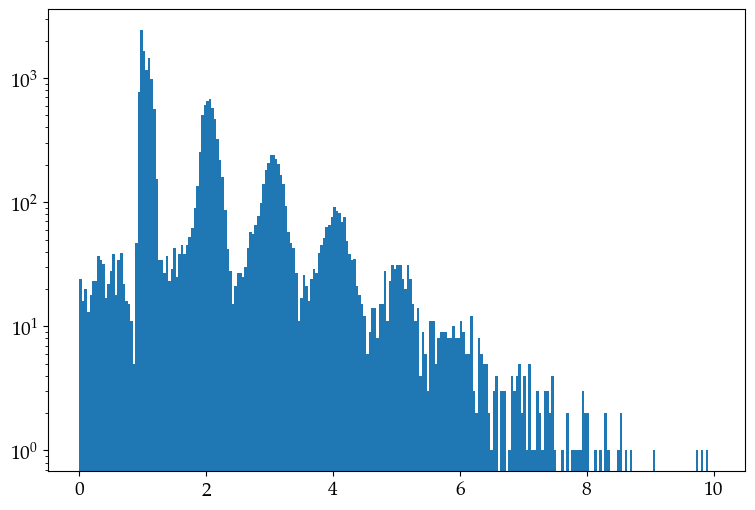

In [54]:
plt.hist(np.concatenate(h_sgd_no_xe[8]), bins=250, range=(0, 10), log=True);

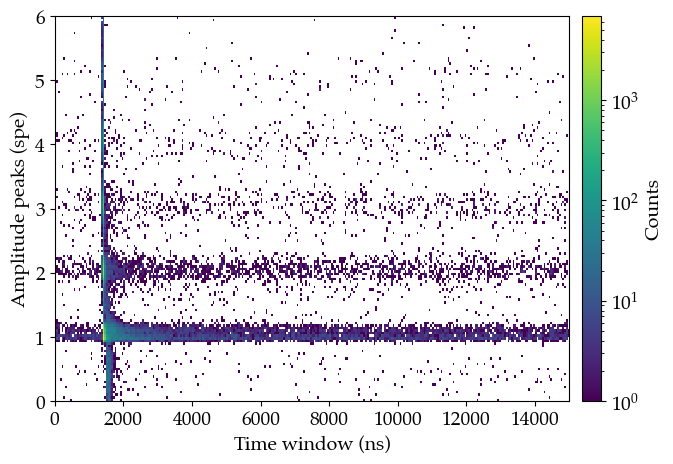

In [109]:
sel_ch = 7

fig = plt.figure(figsize=(8, 5))
#h   = plt.hist2d(np.concatenate(idx_thr_no_xe[sel_ch])*2, np.concatenate(h_sgd_no_xe[sel_ch]), bins=(500, 200), range=((0, 15000), (0, 10)), cmin=1, norm=LogNorm())
h   = plt.hist2d(np.concatenate(np.concatenate([2*idx_thr_no_xe[ch] for ch in normal_chs])), np.concatenate(np.concatenate([h_sgd_no_xe[ch] for ch in normal_chs])), bins=(300, 150), range=((0, 15000), (0, 6)), cmin=1, norm=LogNorm())
plt.xlabel('Time window (ns)',      fontsize=14)
plt.ylabel('Amplitude peaks (spe)', fontsize=14)
plt.colorbar(h[3], label='Counts', pad=0.02)
plt.show()

In [78]:
def concat_ampl_and_times(indexes, heights):
    all_indexes = {}
    all_heights = {}
    for ch in normal_chs:
        indexes_conc = np.array([])
        heights_conc = np.array([])
        for i, j in zip(indexes[ch], heights[ch]):
            if len(i)==0:
                continue
            if np.any(np.array(i) < 680):
                continue
            for ii,jj in zip(i,j):
                indexes_conc = np.append(indexes_conc, ii)
                heights_conc = np.append(heights_conc, jj)
        timestamps  = 2*indexes_conc
        sum_heights = [np.sum(heights_conc[timestamps == timestamp]) for timestamp in np.unique(timestamps)]
        all_indexes[ch] = np.unique(timestamps)
        all_heights[ch] = sum_heights
    return all_indexes, all_heights

In [79]:
idx_thr_no_xe_no_btt_conc, h_sgd_no_xe_no_btt_conc = concat_ampl_and_times(idx_thr_no_xe, h_sgd_no_xe)
idx_thr_xe1_no_btt_conc, h_sgd_xe1_no_btt_conc     = concat_ampl_and_times(idx_thr_xe1,   h_sgd_xe1)
idx_thr_xe2_no_btt_conc, h_sgd_xe2_no_btt_conc     = concat_ampl_and_times(idx_thr_xe2,   h_sgd_xe2)

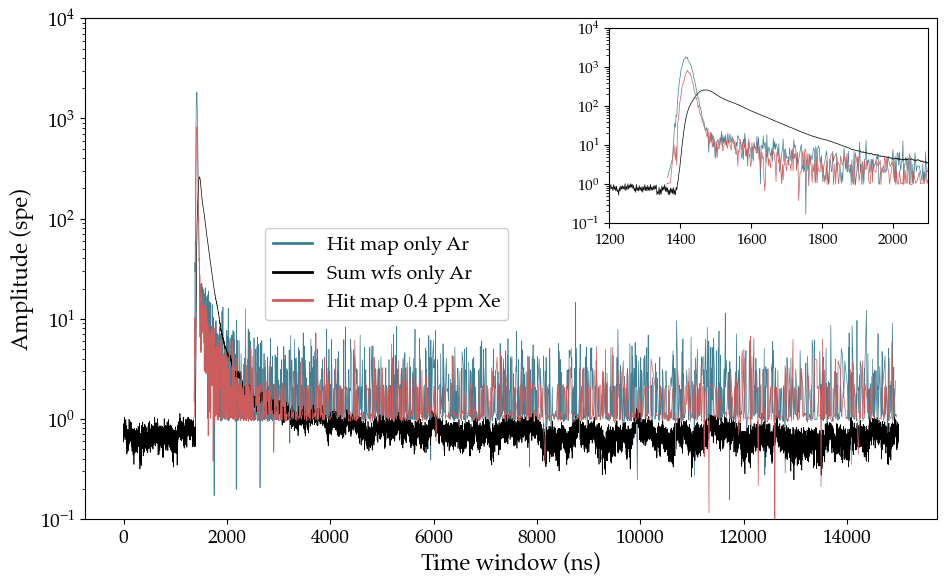

In [112]:
sum_wfs_no_xe = np.sum(subt_wfs_no_xe[sel_ch], axis=0)
sum_wfs_xe1   = np.sum(subt_wfs_xe1  [sel_ch], axis=0)
sum_wfs_xe2   = np.sum(subt_wfs_xe2  [sel_ch], axis=0)

fig = plt.figure(figsize=(11, 6.5))
plt.plot(idx_thr_no_xe_no_btt_conc[sel_ch],  h_sgd_no_xe_no_btt_conc[sel_ch],  lw=0.5, label='Hit map only Ar',      color=fav_col)
plt.plot(2*np.arange(len(sum_wfs_no_xe)), sum_wfs_no_xe/len(subt_wfs_no_xe[sel_ch]), lw=0.5, label='Sum wfs only Ar', color='k')
plt.plot(idx_thr_xe1_no_btt_conc[sel_ch], h_sgd_xe1_no_btt_conc[sel_ch], lw=0.5, label='Hit map 0.4 ppm Xe', color='indianred')
#plt.plot(unique_timestamps2, sum_amplitudes2, linewidth=0.5, label='Hit map xe 0.6 ppm', color='orange')

plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (spe)',  fontsize=16)
plt.ylim(1e-1, 1e4)
plt.yscale('log')
#leg = plt.legend(loc='upper center', framealpha=1, fontsize=14)
leg = plt.legend(bbox_to_anchor=(0.2, 0.6), framealpha=1, fontsize=14)
for line in leg.get_lines():
    line.set_linewidth(2)
    
ax_inset = fig.add_axes([0.602, 0.565, 0.29, 0.30])
ax_inset.plot(idx_thr_no_xe_no_btt_conc[sel_ch],  h_sgd_no_xe_no_btt_conc[sel_ch],  lw=0.5, c=fav_col)
ax_inset.plot(2*np.arange(len(sum_wfs_no_xe)), sum_wfs_no_xe/len(subt_wfs_no_xe[sel_ch]), linewidth=0.5, color='k')
ax_inset.plot(idx_thr_xe1_no_btt_conc[sel_ch], h_sgd_xe1_no_btt_conc[sel_ch], lw=0.5, c='indianred')
#ax_inset.plot(unique_timestamps2, sum_amplitudes2, lw=0.5, c='orange')
ax_inset.set_xlim(1200, 2100)
ax_inset.set_ylim(1e-1, 1e4)
ax_inset.set_yscale('log')
ax_inset.tick_params(axis='x', labelsize=11)
ax_inset.tick_params(axis='y', labelsize=11)

#plt.savefig('/Users/romoluque_c/LEGEND/BACON/Analysis_documentation/images/hit_map_and_summed_wfs_norm.pdf', bbox_inches='tight')
plt.show()

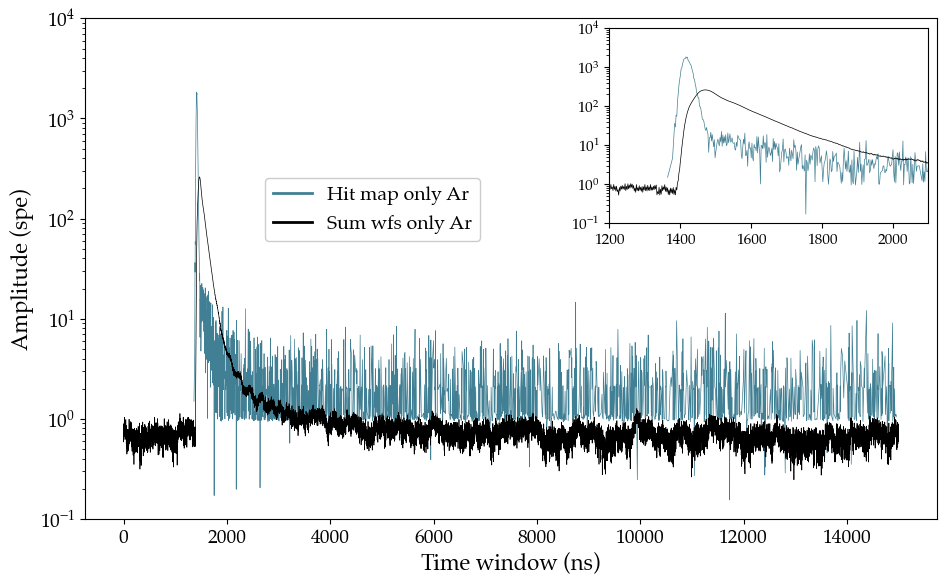

In [117]:
sum_wfs_no_xe = np.sum(subt_wfs_no_xe[sel_ch], axis=0)
sum_wfs_xe1   = np.sum(subt_wfs_xe1  [sel_ch], axis=0)
sum_wfs_xe2   = np.sum(subt_wfs_xe2  [sel_ch], axis=0)

fig = plt.figure(figsize=(11, 6.5))
plt.plot(idx_thr_no_xe_no_btt_conc[sel_ch],  h_sgd_no_xe_no_btt_conc[sel_ch],  lw=0.5, label='Hit map only Ar',      color=fav_col)
plt.plot(2*np.arange(len(sum_wfs_no_xe)), sum_wfs_no_xe/len(subt_wfs_no_xe[sel_ch]), lw=0.5, label='Sum wfs only Ar', color='k')

plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (spe)',  fontsize=16)
plt.ylim(1e-1, 1e4)
plt.yscale('log')
#leg = plt.legend(loc='upper center', framealpha=1, fontsize=14)
leg = plt.legend(bbox_to_anchor=(0.2, 0.7), framealpha=1, fontsize=14)
for line in leg.get_lines():
    line.set_linewidth(2)
    
ax_inset = fig.add_axes([0.602, 0.565, 0.29, 0.30])
ax_inset.plot(idx_thr_no_xe_no_btt_conc[sel_ch],  h_sgd_no_xe_no_btt_conc[sel_ch],  lw=0.5, c=fav_col)
ax_inset.plot(2*np.arange(len(sum_wfs_no_xe)), sum_wfs_no_xe/len(subt_wfs_no_xe[sel_ch]), linewidth=0.5, color='k')
ax_inset.set_xlim(1200, 2100)
ax_inset.set_ylim(1e-1, 1e4)
ax_inset.set_yscale('log')
ax_inset.tick_params(axis='x', labelsize=11)
ax_inset.tick_params(axis='y', labelsize=11)

#plt.savefig('/Users/romoluque_c/LEGEND/BACON/Analysis_documentation/images/hit_map_and_summed_wfs_norm.pdf', bbox_inches='tight')
plt.show()

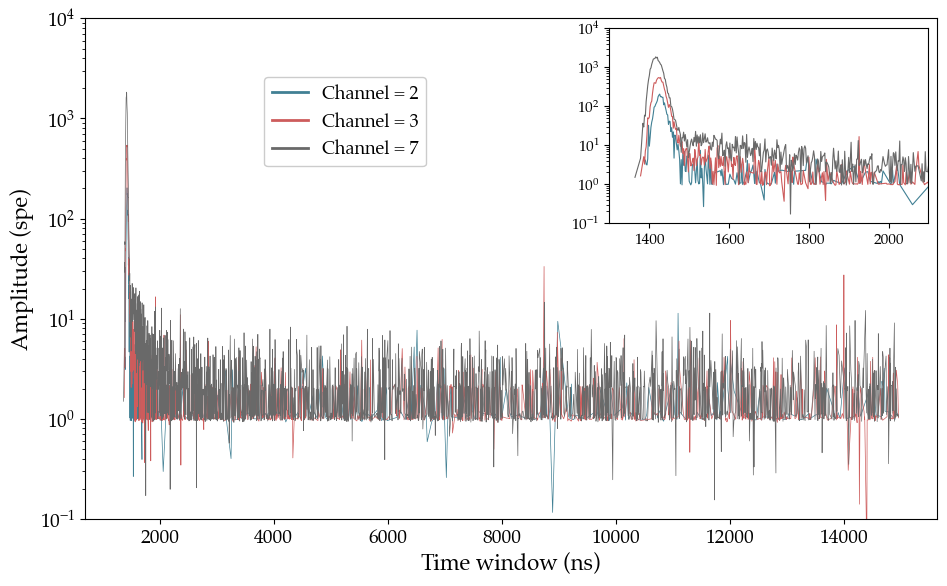

In [115]:
fig = plt.figure(figsize=(11, 6.5))
for ch, col in zip([2, 3, 7], [fav_col, 'indianred', 'dimgrey']):
    plt.plot(idx_thr_no_xe_no_btt_conc[ch], h_sgd_no_xe_no_btt_conc[ch], lw=0.5, label=f'Channel = {ch}', c=col)

plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (spe)',  fontsize=16)
plt.ylim(1e-1, 1e4)
plt.yscale('log')
#leg = plt.legend(loc='upper center', framealpha=1, fontsize=14)
leg = plt.legend(bbox_to_anchor=(0.2, 0.9), framealpha=1, fontsize=13)
for line in leg.get_lines():
    line.set_linewidth(2)
    
ax_inset = fig.add_axes([0.602, 0.565, 0.29, 0.30])
for ch, col in zip([2, 3, 7], [fav_col, 'indianred', 'dimgrey']):
    ax_inset.plot(idx_thr_no_xe_no_btt_conc[ch],  h_sgd_no_xe_no_btt_conc[ch],  lw=0.8, c=col)
ax_inset.set_xlim(1300, 2100)
ax_inset.set_ylim(1e-1, 1e4)
ax_inset.set_yscale('log')
ax_inset.tick_params(axis='x', labelsize=11)
ax_inset.tick_params(axis='y', labelsize=11)

#plt.savefig('/Users/romoluque_c/Desktop/hit_map_and_summed_wfs_norm_3chs.pdf', bbox_inches='tight')
plt.show()